In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YirpBz2JeIQ10LKmg8jW")
project = rf.workspace("project-ekep6").project("drowsiness-detection-ej8jx")
version = project.version(11)
dataset = version.download("yolov8")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to drowsiness-detection-11 in yolov8:: 100%|██████████| 4284/4284 [00:00<00:00, 6662.45it/s]


In [ ]:
import os
import shutil
from pathlib import Path
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Paths
dataset_dir = Path('/content/drowsiness-detection-11/train')
images_dir = dataset_dir / 'images'
labels_dir = dataset_dir / 'labels'

aug_images_dir = dataset_dir / 'images_augmented'
aug_labels_dir = dataset_dir / 'labels_augmented'

aug_images_dir.mkdir(parents=True, exist_ok=True)
aug_labels_dir.mkdir(parents=True, exist_ok=True)

# Define augmentations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.MotionBlur(p=0.1),
    A.RandomGamma(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.3)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Helper to read YOLO annotations
def read_yolo_annotation(label_path):
    with open(label_path, 'r') as f:
        lines = f.read().strip().split('\n')
    bboxes = []
    labels = []
    for line in lines:
        if line.strip() == '':
            continue
        parts = line.strip().split()
        if len(parts) != 5:
            continue
        labels.append(int(parts[0]))
        bboxes.append([float(x) for x in parts[1:]])
    return bboxes, labels

# Augment dataset
print("Starting augmentation...")
success_count, fail_count = 0, 0

for image_file in sorted(images_dir.glob('*.jpg')):
    try:
        label_file = labels_dir / f"{image_file.stem}.txt"
        if not label_file.exists():
            print(f"Missing label for {image_file.name}")
            fail_count += 1
            continue

        # Load image
        image = cv2.imread(str(image_file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load annotations
        bboxes, labels = read_yolo_annotation(label_file)
        if not bboxes:
            continue

        # Apply augmentation
        augmented = augmentations(image=image, bboxes=bboxes, class_labels=labels)
        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['class_labels']

        # Save augmented image
        aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
        aug_image_path = aug_images_dir / f"{image_file.stem}_aug.jpg"
        cv2.imwrite(str(aug_image_path), aug_image_bgr)

        # Save corresponding label
        aug_label_path = aug_labels_dir / f"{image_file.stem}_aug.txt"
        with open(aug_label_path, 'w') as f:
            for cls, bbox in zip(aug_labels, aug_bboxes):
                bbox_str = ' '.join([f"{x:.6f}" for x in bbox])
                f.write(f"{cls} {bbox_str}\n")

        success_count += 1

    except Exception as e:
        print(f"Failed to process {image_file.name}: {e}")
        fail_count += 1

print(f"\n✅ Augmentation complete: {success_count} succeeded, {fail_count} failed.")

# Optionally, merge back to original dataset
merge = True
if merge:
    for img in aug_images_dir.glob('*.jpg'):
        shutil.copy(img, images_dir / img.name)
    for lbl in aug_labels_dir.glob('*.txt'):
        shutil.copy(lbl, labels_dir / lbl.name)
    print("✅ Augmented data merged into original training dataset.")


ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.


Starting augmentation...

✅ Augmentation complete: 1748 succeeded, 0 failed.
✅ Augmented data merged into original training dataset.


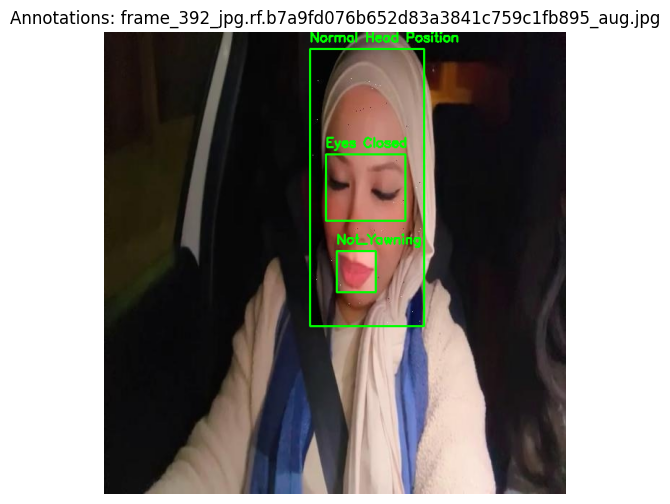

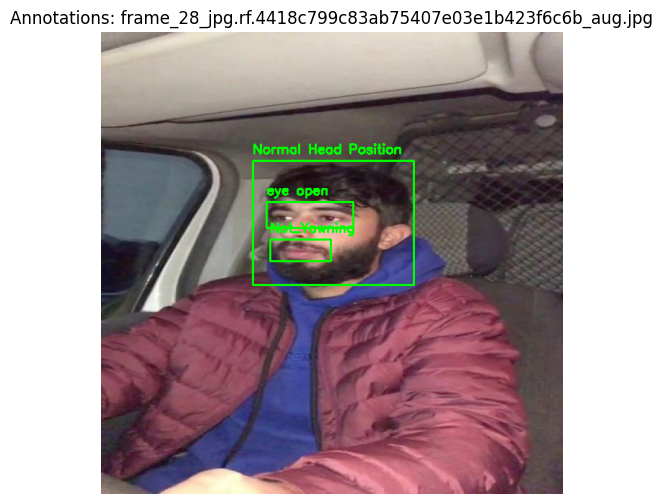

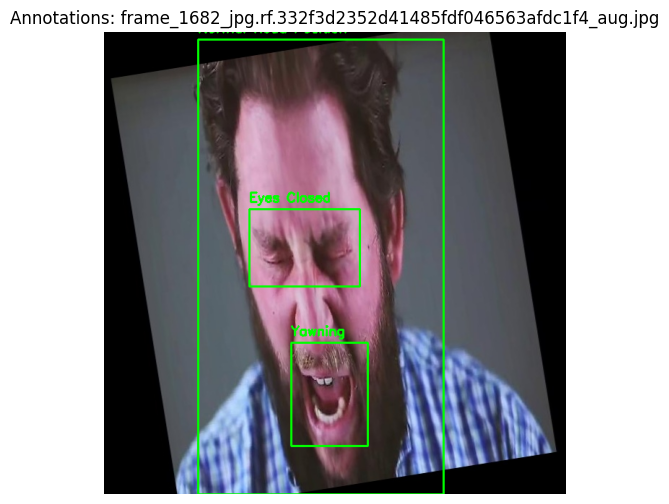

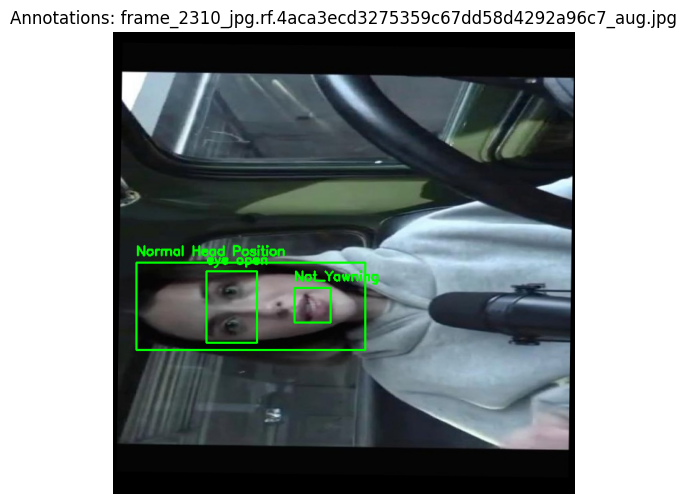

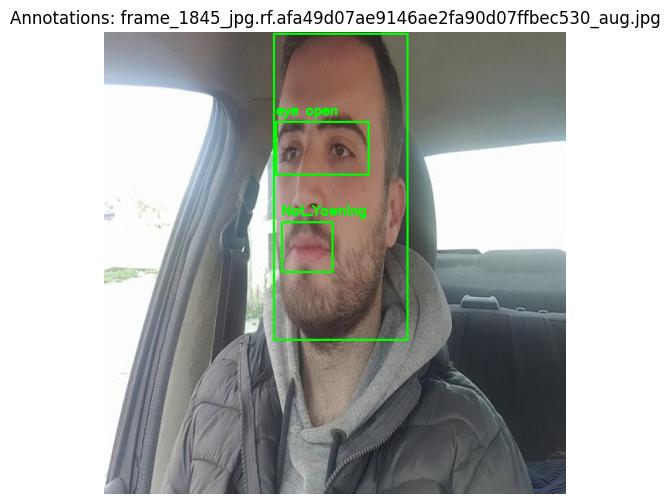

In [ ]:
import os
import random
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

# Paths
image_dir = Path('/content/drowsiness-detection-11/train/images_augmented')
label_dir = Path('/content/drowsiness-detection-11/train/labels_augmented')
class_names = [
    "Eyes Closed", "Hand Off Steering Wheel", "Head Tilted Down",
    "Normal Head Position", "Not_Yawning", "Yawning", "eye open"
]

# Function to draw bounding boxes
def draw_annotations(image_path, label_path):
    image = cv2.imread(str(image_path))
    h, w, _ = image.shape

    if not label_path.exists():
        print(f"⚠️ Label file not found for {image_path.name}")
        return image

    with open(label_path, 'r') as f:
        lines = f.read().strip().split('\n')

    for line in lines:
        if line.strip() == '':
            continue
        cls, x_center, y_center, box_w, box_h = map(float, line.split())
        x1 = int((x_center - box_w / 2) * w)
        y1 = int((y_center - box_h / 2) * h)
        x2 = int((x_center + box_w / 2) * w)
        y2 = int((y_center + box_h / 2) * h)

        cls = int(cls)
        label = class_names[cls] if cls < len(class_names) else f"Class {cls}"

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 255, 0), 2)

    return image

# Sample and display images
sample_files = random.sample(list(image_dir.glob('*.jpg')), 5)

for img_path in sample_files:
    label_path = label_dir / (img_path.stem + '.txt')
    annotated_img = draw_annotations(img_path, label_path)

    # Convert BGR to RGB for matplotlib
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 6))
    plt.imshow(annotated_img)
    plt.title(f"Annotations: {img_path.name}")
    plt.axis('off')
    plt.show()


In [ ]:
import shutil
from pathlib import Path

# Paths
original_train_images = Path("/content/drowsiness-detection-11/train/images")
original_train_labels = Path("/content/drowsiness-detection-11/train/labels")
augmented_images = Path("/content/drowsiness-detection-11/train/images_augmented")
augmented_labels = Path("/content/drowsiness-detection-11/train/labels_augmented")

# Target: Merge into original train dir
def merge_datasets():
    for aug_dir, orig_dir in [(augmented_images, original_train_images), (augmented_labels, original_train_labels)]:
        for file in aug_dir.glob("*"):
            target = orig_dir / file.name
            if not target.exists():
                shutil.copy(file, target)
    print("✅ Merging complete! Augmented data is added to the training set.")

merge_datasets()


✅ Merging complete! Augmented data is added to the training set.


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.5/974.5 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
from ultralytics import YOLO

# Load YOLOv8n or your chosen model
model = YOLO('yolov8n.pt')  # Replace with your preferred model like 'yolov8s.pt'

# Train the model
results = model.train(
    data='/content/drowsiness-detection-11/data.yaml',
    epochs=30,
    imgsz=640,
    batch=16,
    patience=5,
    name='drowsiness_yolov8n',
    device=0  # Use 'cpu' if no GPU
)

# Evaluate the model on validation set
metrics = model.val()

# Print results summary
print("Validation Results:")
print(metrics)

# Export the trained model to ONNX format
export_path = model.export(format='onnx')
print(f"Model exported to ONNX at: {export_path}")



Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drowsiness-detection-11/data.yaml, epochs=30, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=drowsiness_yolov8n2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

train: Scanning /content/drowsiness-detection-11/train/labels... 3502 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3502/3502 [00:06<00:00, 505.63it/s]


train: New cache created: /content/drowsiness-detection-11/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 174, len(boxes) = 10622. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drowsiness-detection-11/valid/labels... 238 images, 0 backgrounds, 0 corrupt: 100%|██████████| 238/238 [00:00<00:00, 488.42it/s]


val: New cache created: /content/drowsiness-detection-11/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 37, len(boxes) = 712. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/drowsiness_yolov8n2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/drowsiness_yolov8n2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.09G      1.597      2.634      1.602         61        640: 100%|██████████| 219/219 [01:06<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

                   all        238        712       0.41      0.508      0.448       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.57G      1.416      1.684      1.429         92        640: 100%|██████████| 219/219 [01:01<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.55it/s]

                   all        238        712      0.607      0.547      0.573      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.59G      1.382      1.457      1.398         69        640: 100%|██████████| 219/219 [01:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

                   all        238        712       0.62      0.682      0.646      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.6G      1.336      1.307      1.373         65        640: 100%|██████████| 219/219 [01:01<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


                   all        238        712        0.6      0.699      0.677       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.62G      1.294      1.197      1.344         77        640: 100%|██████████| 219/219 [01:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.64it/s]

                   all        238        712      0.777      0.701      0.746      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.64G      1.259      1.122      1.316         49        640: 100%|██████████| 219/219 [01:01<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.67it/s]

                   all        238        712      0.795      0.707      0.768      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.66G      1.221      1.075      1.302         61        640: 100%|██████████| 219/219 [01:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]

                   all        238        712      0.813      0.709      0.783      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.67G      1.215      1.019      1.289         81        640: 100%|██████████| 219/219 [01:01<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.61it/s]


                   all        238        712      0.688       0.77      0.771      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.69G      1.189     0.9815      1.272         68        640: 100%|██████████| 219/219 [01:01<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.62it/s]


                   all        238        712      0.797      0.722      0.775      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.71G      1.172     0.9639      1.265         79        640: 100%|██████████| 219/219 [01:01<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.74it/s]

                   all        238        712       0.78      0.764      0.797      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.72G      1.151     0.9233      1.246         58        640: 100%|██████████| 219/219 [01:01<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.67it/s]

                   all        238        712      0.751      0.817      0.805      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.74G      1.131     0.9064      1.238         60        640: 100%|██████████| 219/219 [01:01<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.64it/s]

                   all        238        712      0.795      0.754      0.795      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.76G      1.116     0.8799      1.231         78        640: 100%|██████████| 219/219 [01:02<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.65it/s]

                   all        238        712      0.827      0.796      0.832      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.78G      1.121     0.8701      1.235         72        640: 100%|██████████| 219/219 [01:02<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.67it/s]

                   all        238        712      0.815      0.774      0.821      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.79G      1.097     0.8458      1.214         60        640: 100%|██████████| 219/219 [01:02<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.61it/s]

                   all        238        712      0.789      0.767      0.818      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.81G      1.076     0.8407      1.209         71        640: 100%|██████████| 219/219 [01:02<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.64it/s]

                   all        238        712       0.83      0.787      0.831       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.82G      1.059     0.8065      1.196         69        640: 100%|██████████| 219/219 [01:02<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]

                   all        238        712      0.845      0.778      0.835      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.84G      1.058     0.7947       1.19         72        640: 100%|██████████| 219/219 [01:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.53it/s]

                   all        238        712      0.831      0.792      0.842      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.86G      1.032     0.7726      1.179         64        640: 100%|██████████| 219/219 [01:01<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.44it/s]

                   all        238        712      0.777       0.83      0.836      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.88G       1.03     0.7632      1.174         55        640: 100%|██████████| 219/219 [01:01<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.43it/s]

                   all        238        712      0.811      0.801      0.839      0.481


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.89G      1.011     0.6682      1.217         38        640: 100%|██████████| 219/219 [00:59<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.69it/s]

                   all        238        712      0.794      0.813      0.831      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.91G     0.9867     0.6382      1.207         41        640: 100%|██████████| 219/219 [00:57<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.63it/s]

                   all        238        712      0.785      0.833      0.827      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.93G     0.9672     0.6207      1.187         43        640: 100%|██████████| 219/219 [00:58<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.71it/s]


                   all        238        712      0.835      0.825      0.847      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.94G     0.9529     0.6011      1.178         40        640: 100%|██████████| 219/219 [00:57<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]

                   all        238        712      0.807      0.832      0.841      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.96G     0.9434     0.5913      1.169         44        640: 100%|██████████| 219/219 [00:57<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.84it/s]

                   all        238        712      0.807      0.835      0.842      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.98G     0.9242     0.5746      1.159         40        640: 100%|██████████| 219/219 [00:58<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.64it/s]

                   all        238        712      0.811      0.814      0.835      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         3G     0.9088     0.5573      1.145         43        640: 100%|██████████| 219/219 [00:57<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.37it/s]

                   all        238        712      0.809       0.83      0.834      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.01G      0.895     0.5474      1.141         41        640: 100%|██████████| 219/219 [00:57<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.74it/s]

                   all        238        712      0.826      0.815      0.849      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.03G     0.8856     0.5376      1.138         41        640: 100%|██████████| 219/219 [00:58<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]

                   all        238        712      0.804      0.829      0.844        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.05G      0.875     0.5274       1.13         47        640: 100%|██████████| 219/219 [00:57<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


                   all        238        712      0.809      0.838       0.85      0.499

30 epochs completed in 0.532 hours.
Optimizer stripped from runs/detect/drowsiness_yolov8n2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/drowsiness_yolov8n2/weights/best.pt, 6.2MB

Validating runs/detect/drowsiness_yolov8n2/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


                   all        238        712      0.826      0.815      0.849      0.502
           Eyes Closed        107        108      0.864      0.825      0.879      0.469
Hand Off Steering Wheel         50         51      0.802      0.784      0.807      0.464
      Head Tilted Down         32         32       0.73      0.594      0.738       0.44
  Normal Head Position        204        204       0.89      0.936      0.926      0.669
           Not_Yawning        155        155      0.908      0.895      0.899      0.575
               Yawning         41         41      0.705      0.756      0.733      0.385
              eye open        121        121      0.881      0.917      0.961      0.513
Speed: 0.4ms preprocess, 3.4ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/detect/drowsiness_yolov8n2
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 

val: Scanning /content/drowsiness-detection-11/valid/labels.cache... 238 images, 0 backgrounds, 0 corrupt: 100%|██████████| 238/238 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 37, len(boxes) = 712. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


                   all        238        712      0.826      0.815      0.849      0.502
           Eyes Closed        107        108      0.864      0.824      0.879       0.47
Hand Off Steering Wheel         50         51      0.802      0.784      0.807      0.464
      Head Tilted Down         32         32       0.73      0.594      0.737       0.44
  Normal Head Position        204        204       0.89      0.936      0.926      0.667
           Not_Yawning        155        155      0.908      0.895      0.899      0.577
               Yawning         41         41      0.704      0.756      0.733      0.382
              eye open        121        121      0.881      0.917      0.962      0.512
Speed: 1.8ms preprocess, 4.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/drowsiness_yolov8n22
Validation Results:
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metri

In [ ]:
!zip -r '/content/DDD_v2.zip' '/content'

Streaming output truncated to the last 5000 lines.
  adding: content/drowsiness-detection-11/train/labels_augmented/frame_546_jpg.rf.7ef419719df69e9a25f7f5862cd4f969_aug.txt (deflated 30%)
  adding: content/drowsiness-detection-11/train/labels_augmented/frame_165_jpg.rf.cb7706473b4ea43d03eb952df487a84f_aug.txt (deflated 43%)
  adding: content/drowsiness-detection-11/train/labels_augmented/frame_854_jpg.rf.57cefd1926a81d53f8ecac75d2e0a94c_aug.txt (deflated 38%)
  adding: content/drowsiness-detection-11/train/labels_augmented/frame_2436_jpg.rf.20c610c2a75bac075b6c7ed9d76871ec_aug.txt (deflated 43%)
  adding: content/drowsiness-detection-11/train/labels_augmented/frame_812_jpg.rf.2726395c48cc8b07a3f72e1514cf4d94_aug.txt (deflated 47%)
  adding: content/drowsiness-detection-11/train/labels_augmented/frame_860_jpg.rf.79a2bc80d1f79004077ed331835d6875_aug.txt (deflated 41%)
  adding: content/drowsiness-detection-11/train/labels_augmented/frame_493_jpg.rf.fee9ad6f318c845ed0a7b50ea061f758_aug.t

In [ ]:
!pip install ultralytics opencv-python


In [ ]:
import cv2
import torch
from ultralytics import YOLO
import os

# === CONFIGURATION ===
model_path = "/content/runs/detect/drowsiness_yolov8n2/weights/best.pt"  # or use "best.onnx"
source_folder = "/content/custom_img"  # folder with images to test
output_folder = "/content/Untitled Folder"
conf_threshold = 0.3  # minimum confidence for detection

# === LOAD MODEL ===
if model_path.endswith('.pt'):
    model = YOLO(model_path)
elif model_path.endswith('.onnx'):
    model = YOLO(model_path)  # ultralytics supports .onnx inference too!
else:
    raise ValueError("Unsupported model format")

# === MAKE OUTPUT FOLDER ===
os.makedirs(output_folder, exist_ok=True)

# === INFERENCE LOOP ===
image_files = [f for f in os.listdir(source_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

for img_name in image_files:
    img_path = os.path.join(source_folder, img_name)
    img = cv2.imread(img_path)

    # Inference
    results = model(img, conf=conf_threshold)

    # Save & visualize results
    res_plotted = results[0].plot()  # result image with boxes
    output_path = os.path.join(output_folder, img_name)
    cv2.imwrite(output_path, res_plotted)

    print(f"Inference done → {output_path}")

print("✅ All done!")



0: 480x640 1 Normal Head Position, 1 Not_Yawning, 1 eye open, 44.9ms
Speed: 1.7ms preprocess, 44.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)
Inference done → /content/Untitled Folder/001_glasses_nonsleepyCombination_196_notdrowsy.jpg

0: 480x640 1 Normal Head Position, 1 eye open, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
Inference done → /content/Untitled Folder/001_glasses_nonsleepyCombination_195_notdrowsy.jpg

0: 480x640 1 Normal Head Position, 1 Yawning, 1 eye open, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
Inference done → /content/Untitled Folder/002_glasses_sleepyCombination_2109_drowsy.jpg

0: 480x640 1 Normal Head Position, 1 Not_Yawning, 1 eye open, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
Inference done → /content/Untitled Folder/001_glasses_nonsleepyCombination_193_notd